In [500]:
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
import tarfile
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [501]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

inceptionv3 = models.inception_v3(pretrained=True) #download and load pretrained inceptionv3 model
model = inceptionv3.to(device)
model.eval()

affine=True, track_running_stats=True)
    )
    (branch5x5_2): BasicConv2d(
      (conv): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3x3dbl_1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3x3dbl_2): BasicConv2d(
      (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3x3dbl_3): BasicConv2d(
      (conv): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch_pool): BasicConv2d(
      (conv): Conv2d(192, 32, kernel_size

In [502]:
try:
    print(len(os.listdir('./data/ILSVRC/Data/DET/test')))
except:
    with tarfile.open('./ILSVRC2017_DET_test_new.tar.gz', 'r:gz') as tar:
        tar.extractall(path='./data')

5500


In [503]:
with open("./data/Classes.txt", 'r') as a_file:
    classes = eval(a_file.read())

classes[950]

'orange'

In [559]:
img = Image.open("./Data/ILSVRC/Data/DET/test/ILSVRC2017_test_00000026.JPEG")

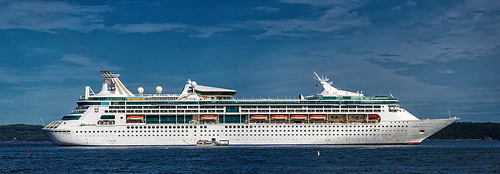

In [560]:
img

In [561]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

preprocess = transforms.Compose([
                transforms.Resize((299,299)),  
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

In [562]:
image_tensor = preprocess(img)
image_tensor = image_tensor.unsqueeze(0)
img_variable = image_tensor.to(device).requires_grad_()

In [563]:
image_tensor.shape

torch.Size([1, 3, 299, 299])

In [564]:
output = inceptionv3.forward(img_variable)
labels, indexes = torch.topk(output, 2)
x_prob = round(torch.max(F.softmax(output, dim=1),1)[0][0].item()*100,4)
print(indexes)
print(x_prob)

tensor([[628, 554]], device='cuda:0')
93.5896


In [565]:
pred = indexes[0][0].item()
print(classes[indexes[0][0].item()])
print(classes[indexes[0][1].item()])

liner, ocean liner
fireboat


In [566]:
y_true = pred
# target = torch.tensor([y_true]).to(device)
target = torch.tensor([1]).to(device)
print(target)

tensor([1], device='cuda:0')


In [567]:
for i in range(10):
    model.zero_grad()

    loss = F.cross_entropy(output, target)

    loss.backward(retain_graph=True)

    eps = .005
    x_grad = torch.sign(img_variable.grad.data)

    img_variable = (img_variable - eps * x_grad).detach()

    img_variable.requires_grad_()

    output = model.forward(img_variable)

    x_adv_pred = classes[torch.max(output, 1)[1][0].item()]

    op_adv_probs = F.softmax(output, dim=1)

    adv_pred_prob = round((torch.max(op_adv_probs, 1)[0][0].item()) * 100, 4)

    print(i)

0
1
2
3
4
5
6
7
8
9


In [568]:
print(x_adv_pred)
print(adv_pred_prob)

goldfish, Carassius auratus
34.6123


In [569]:
def visualize(x, x_adv, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = 10*(x_adv - x)/eps
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon*10,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

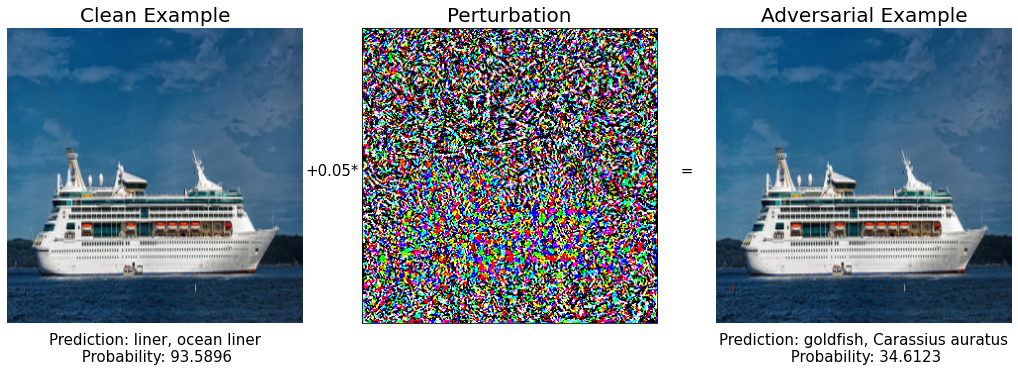

In [570]:
visualize(image_tensor.cpu().detach(), img_variable.cpu().detach(), eps, classes[y_true], x_adv_pred, x_prob, adv_pred_prob)